In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

 [Dataset](https://github.com/ardamavi/Sign-Language-Digits-Dataset.git)

In [9]:
os.chdir('data/Sign-Language-Digits-Dataset')
if os.path.isdir('train/0') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
    
    for i in range(0,10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')
        
        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')
        
        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')

In [10]:
train_path = 'data/Sign-Language-Digits-Dataset/train'
test_path = 'data/Sign-Language-Digits-Dataset/test'
valid_path = 'data/Sign-Language-Digits-Dataset/valid'

In [11]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [13]:
mobile = tf.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 99s 6us/step


In [14]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [15]:
x = mobile.layers[-6].output
output = Dense(units=10, activation='softmax')(x)

In [16]:
model = Model(inputs=mobile.inputs, outputs=output)

In [18]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [20]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=30, verbose=2)

Epoch 1/30
172/172 - 79s - loss: 0.3754 - accuracy: 0.8797 - val_loss: 4.2680 - val_accuracy: 0.2867
Epoch 2/30
172/172 - 78s - loss: 0.0838 - accuracy: 0.9720 - val_loss: 0.0952 - val_accuracy: 0.9600
Epoch 3/30
172/172 - 79s - loss: 0.0663 - accuracy: 0.9801 - val_loss: 0.0976 - val_accuracy: 0.9700
Epoch 4/30
172/172 - 75s - loss: 0.0208 - accuracy: 0.9947 - val_loss: 0.0330 - val_accuracy: 0.9900
Epoch 5/30
172/172 - 76s - loss: 0.0496 - accuracy: 0.9842 - val_loss: 0.5725 - val_accuracy: 0.8200
Epoch 6/30
172/172 - 73s - loss: 0.1087 - accuracy: 0.9679 - val_loss: 0.4848 - val_accuracy: 0.8500
Epoch 7/30
172/172 - 73s - loss: 0.0262 - accuracy: 0.9930 - val_loss: 0.0838 - val_accuracy: 0.9667
Epoch 8/30
172/172 - 72s - loss: 0.0446 - accuracy: 0.9831 - val_loss: 2.0805 - val_accuracy: 0.6733
Epoch 9/30
172/172 - 74s - loss: 0.0475 - accuracy: 0.9877 - val_loss: 0.0184 - val_accuracy: 0.9933
Epoch 10/30
172/172 - 73s - loss: 0.0352 - accuracy: 0.9907 - val_loss: 0.0447 - val_accura

In [22]:
test_labels = test_batches.classes

In [23]:
predictions = model.predict(x=test_batches, verbose=0)

In [24]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [25]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 1 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


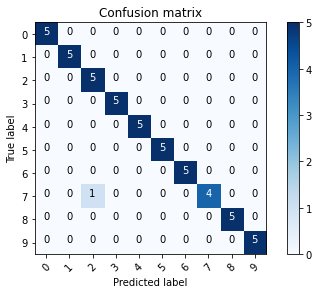

In [27]:
cm_plot_labels = [str(i) for i in range(0, 10)]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels)